In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
import joblib

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

In [2]:
from src.Bayesian import *
from src.Bayesian.problems.config import config_fgt
from src.Bayesian.problems import *
from src.Bayesian.utils.optimizer import Optimizer, ConstantDict
from src.Bayesian.utils.model_evaluation import ModelEval

In [3]:
from src.Bayesian.utils.stream import StreamList
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib

/home/yangjiong/.conda/envs/bayes/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## sampling percentage analysis

In [ ]:
model_name = 'M7_PMH'
result_path = Path(project_root) / 'results' / 'Model_results_new' 
results = joblib.load(result_path / f'{model_name}.joblib')

In [ ]:
def compute_single_entry(iSub, p_bin, info, oral_hit):
    p_lower, p_upper = p_bin
    path, n = info['raw_step_results']
    sample_errors = np.array(info['sample_errors'])
    k_special = 0 if oral_hit['condition'] == 1 else 42
    oral_rolling = np.array(oral_hit['rolling_hits'], dtype=float)
    slist = StreamList(path, n)

    sorted_indices = np.argsort(sample_errors)
    low_idx = int(n * p_lower / 100)
    high_idx = int(n * p_upper / 100)
    top_idxs = sorted_indices[low_idx:high_idx]

    acc_errors = [sample_errors[int(i)] for i in top_idxs]

    k_oral_errors = []
    for i in top_idxs:
        traj = slist[int(i)]
        posts = []
        for sr in traj:
            post = sr['hypo_details'].get(k_special, {}).get('post_max', 0.0)
            try:
                posts.append(float(post))
            except Exception:
                posts.append(0.0)
        posts = pd.Series(posts).rolling(window=16, min_periods=16).mean().to_numpy()
        min_len = min(len(posts), len(oral_rolling))
        valid = ~np.isnan(posts[:min_len])
        if valid.sum() > 0:
            err = np.mean(np.abs(posts[:min_len][valid] - oral_rolling[:min_len][valid]))
        else:
            err = np.nan
        k_oral_errors.append(err)

    return {
        'Subject': iSub,
        'Percentile_Bin': f"{p_lower}-{p_upper}",
        'Accuracy_Error_Mean': np.mean(acc_errors),
        'Accuracy_Error_Std': np.std(acc_errors),
        'KOral_Error_Mean': np.nanmean(k_oral_errors),
        'KOral_Error_Std': np.nanstd(k_oral_errors)
    }


def compute_errors_fine_parallel_with_progress(results, oral_hypo_hits,
                                               bin_edges=range(0, 101, 5),
                                               n_jobs=-1):

    tasks, percentile_bins = [], list(zip(bin_edges[:-1], bin_edges[1:]))
    for iSub, info in results.items():
        if iSub not in oral_hypo_hits or 'raw_step_results' not in info:
            continue
        for p_bin in percentile_bins:
            tasks.append((iSub, p_bin, info, oral_hypo_hits[iSub]))

    with tqdm_joblib(tqdm(total=len(tasks),
                          desc="Computing errors",
                          ncols=80)):

        out = Parallel(n_jobs=n_jobs,batch_size=1)(
            delayed(compute_single_entry)(iSub, p_bin, info, oral_hit)
            for iSub, p_bin, info, oral_hit in tasks
        )

    return pd.DataFrame([r for r in out if r is not None])

In [ ]:
from src.Bayesian.utils.oral_process import Oral_to_coordinate
oral_to_coordinate = Oral_to_coordinate()

processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')
oral_hypo_hits = oral_to_coordinate.get_oral_hypo_hits(learning_data)

In [ ]:
df_eval = compute_errors_fine_parallel_with_progress(results, oral_hypo_hits, n_jobs=120)

In [ ]:
joblib.dump(df_eval, result_path / f'{model_name}_sample_analysis.joblib')

['/home/yangjiong/CategoryLearning_gitcode/results/Model_results_new/M7_PMH_sample_analysis.joblib']

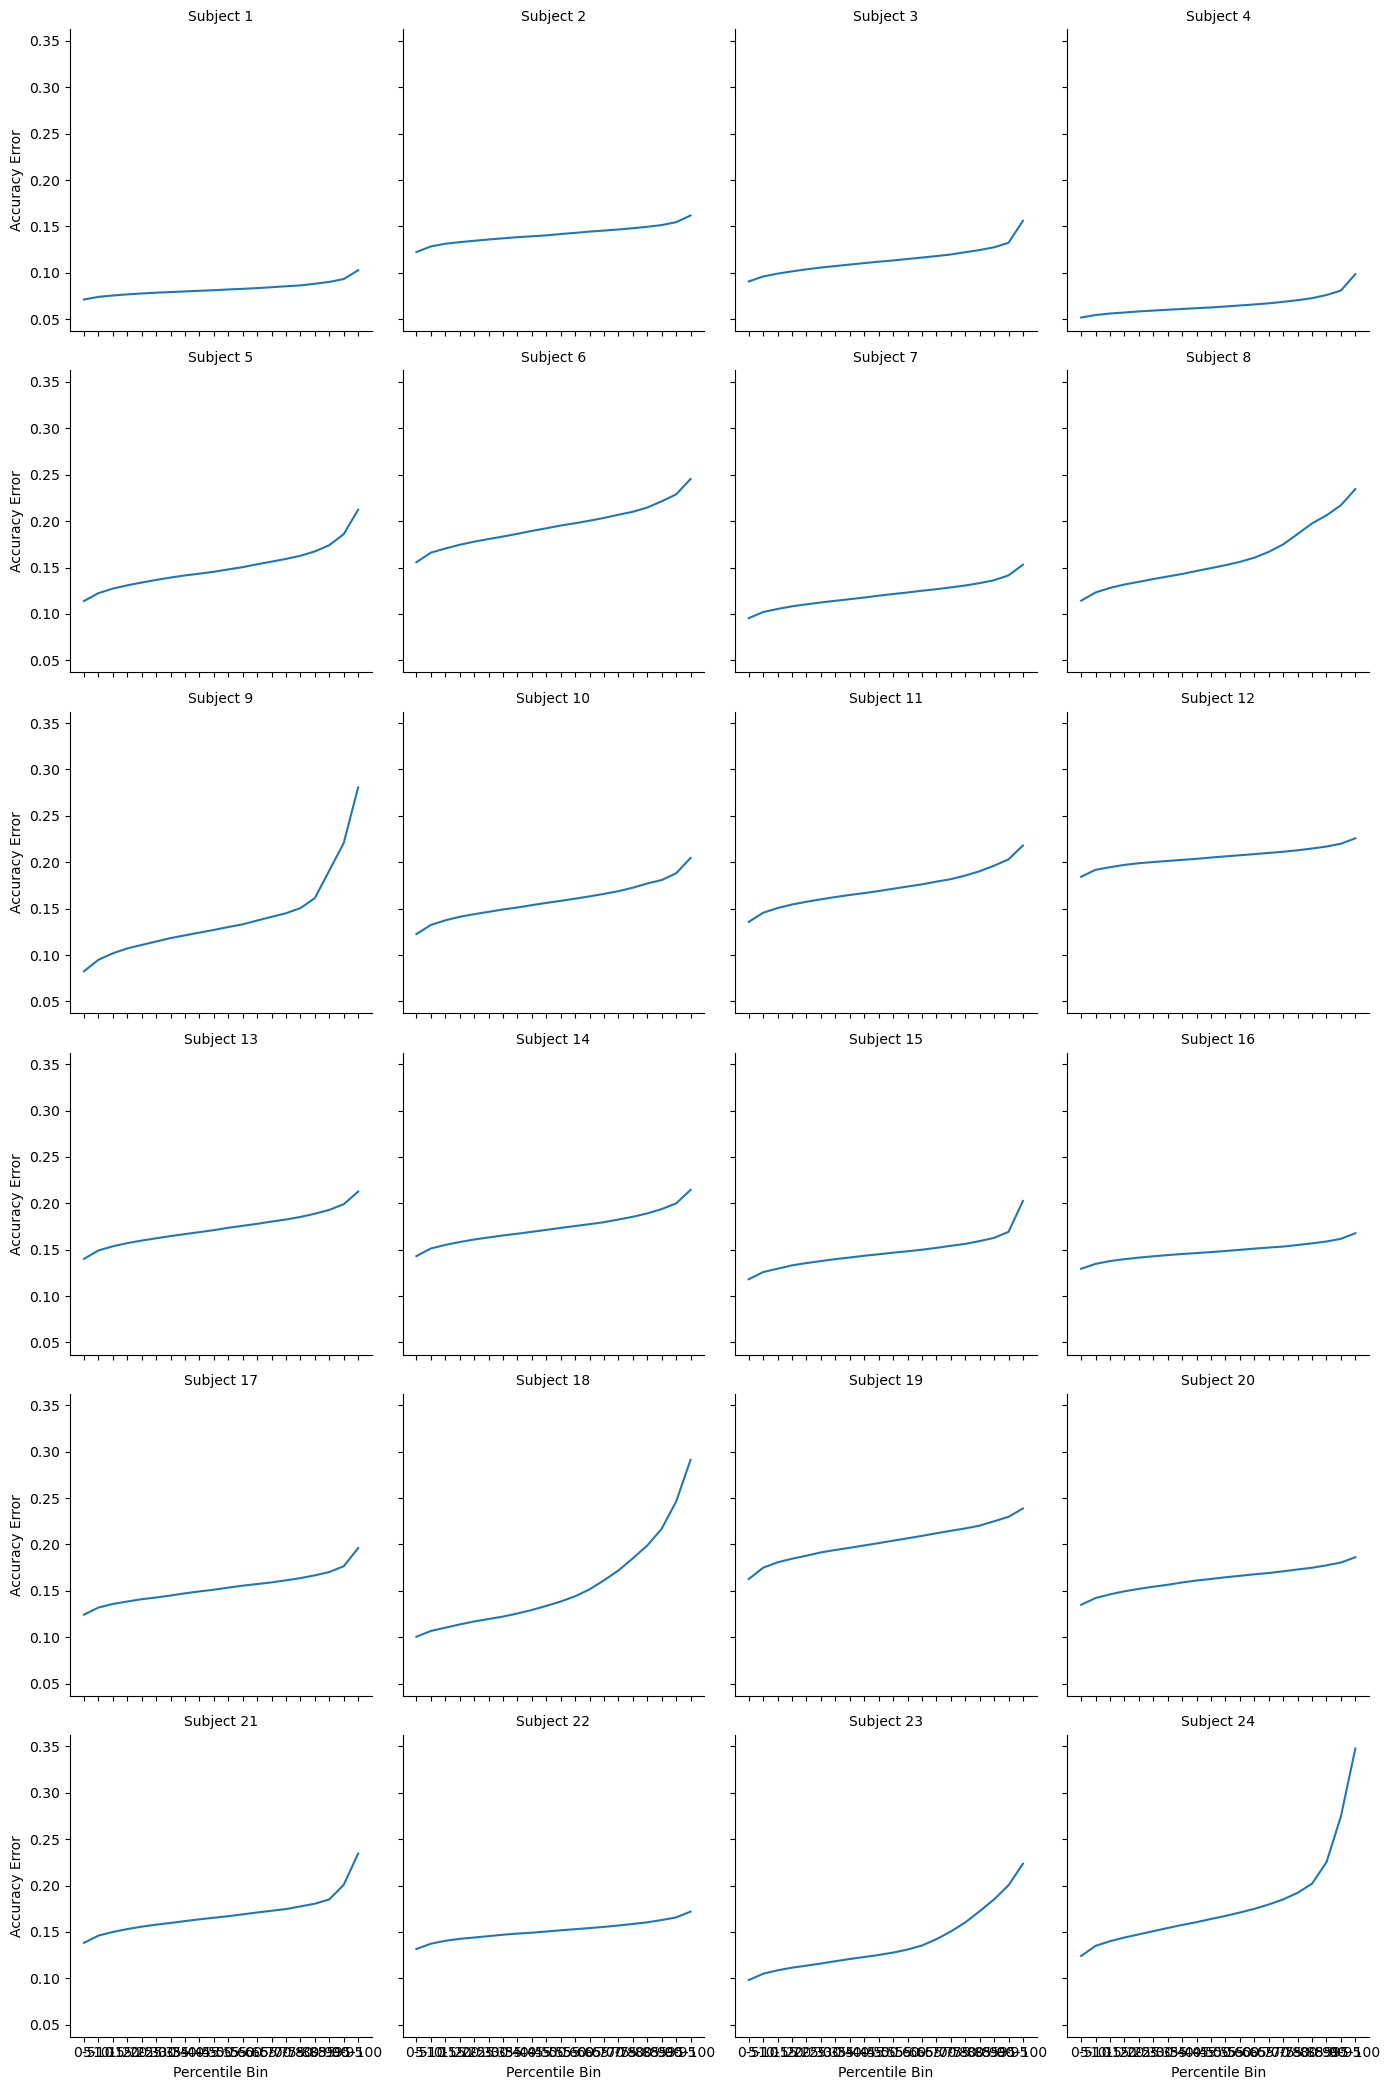

In [ ]:
from matplotlib import pyplot as plt

# Accuracy error plot
g1 = sns.FacetGrid(df_eval, col='Subject', col_wrap=4, height=3.5)
g1.map_dataframe(sns.lineplot, x='Percentile_Bin', y='Accuracy_Error')
g1.set_axis_labels("Percentile Bin", "Accuracy Error")
g1.set_titles("Subject {col_name}")
# g1.suptitle("Accuracy Error vs. Top Trajectory Percentile", y=1.02)
plt.tight_layout()

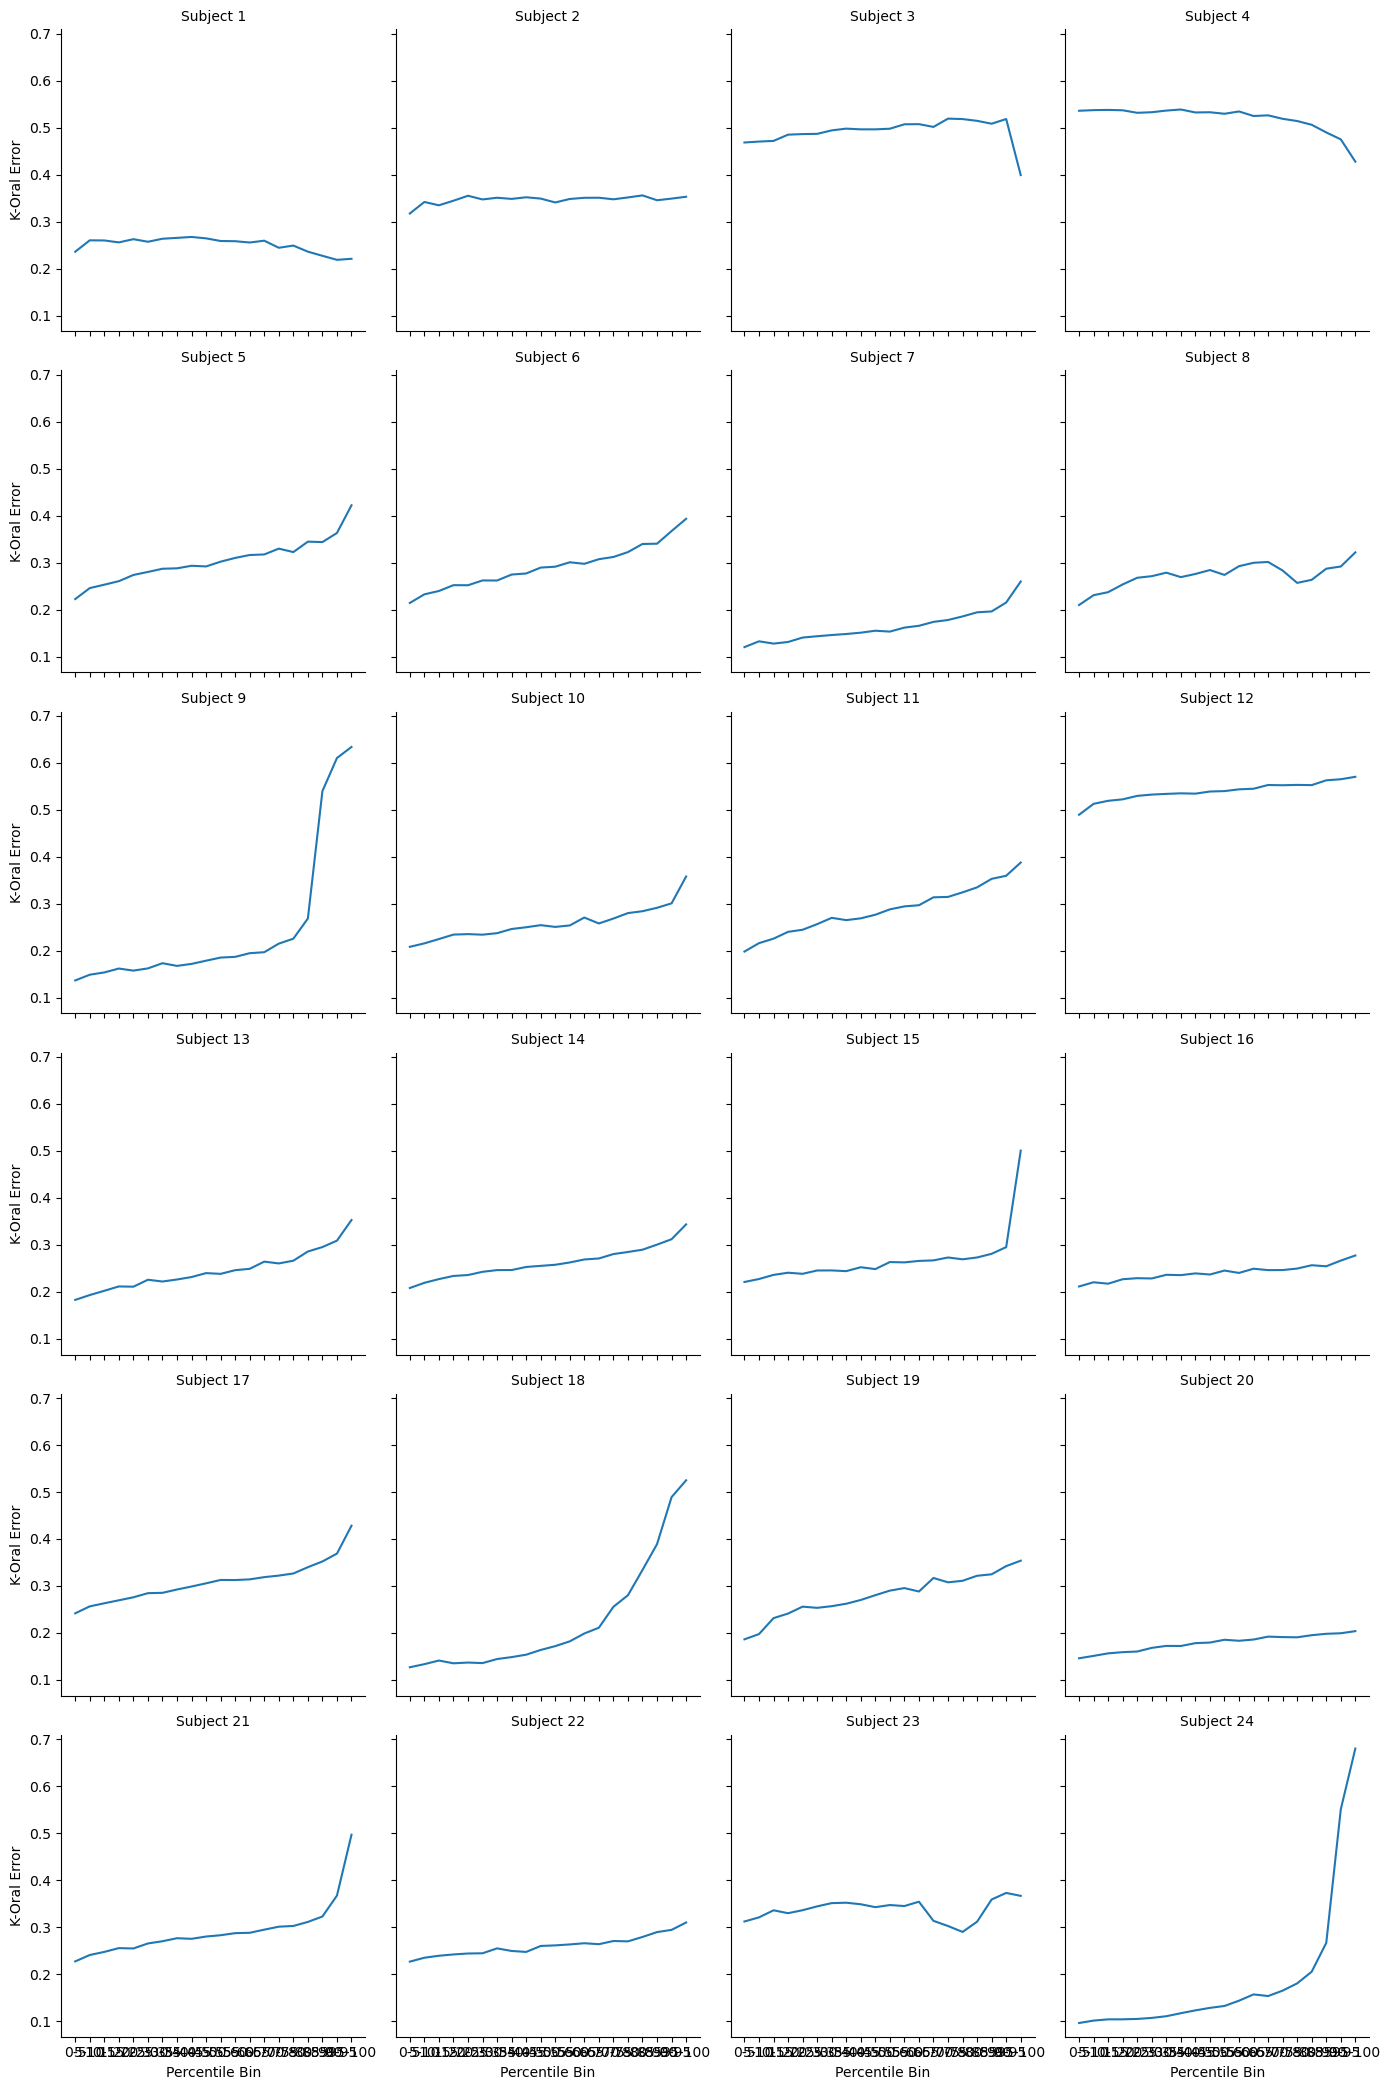

In [ ]:
# K-Oral error plot
g2 = sns.FacetGrid(df_eval, col='Subject', col_wrap=4, height=3.5)
g2.map_dataframe(sns.lineplot, x='Percentile_Bin', y='KOral_Error')
g2.set_axis_labels("Percentile Bin", "K-Oral Error")
g2.set_titles("Subject {col_name}")
# g2.suptitle("K-Oral Error vs. Top Trajectory Percentile", y=1.02)
plt.tight_layout()

## _____

In [17]:
from arviz import waic, loo, from_dict

def extract_log_lik_matrix(path: str, n: int) -> np.ndarray:
    """
    从 raw_step_results 中加载所有 trajectory 的逐 trial log-likelihood。
    返回矩阵 shape = (n_samples, n_trials)
    """
    slist = StreamList(path, n)
    log_lik_list = []
    
    for traj in slist:
        traj_loglik = []
        for sr in traj:
            logp = sr.get("best_log_likelihood", None)
            if logp is None:
                raise ValueError("log_likelihood missing in step result.")
            traj_loglik.append(float(logp))
        log_lik_list.append(traj_loglik)

    return np.array(log_lik_list)  # shape: [n_samples, n_trials]

def compute_waic_loo_from_results(results: dict, subject_ids=None):
    """
    对每个被试，从 raw_step_results 中提取 log-likelihood，然后计算 WAIC 和 PSIS-LOO。
    返回 DataFrame，列为 WAIC, p_WAIC, LOO, p_LOO。
    """
    records = []
    subject_ids = subject_ids or list(results.keys())
    
    for iSub in tqdm(subject_ids, desc="Computing WAIC/LOO"):
        info = results.get(iSub, None)
        if not info or "raw_step_results" not in info:
            continue

        path, n = info["raw_step_results"]
        try:
            log_lik = extract_log_lik_matrix(path, n)
        except Exception as e:
            print(f"[Warning] Failed to load {iSub}: {e}")
            continue

        # 需要转换为 ArviZ 格式
        az_data = from_dict(log_likelihood={"obs": log_lik})
        waic_result = waic(az_data)
        loo_result = loo(az_data, reff=1.0)

        records.append({
            "Subject": iSub,
            "WAIC": waic_result.waic,
            "p_WAIC": waic_result.p_waic,
            "LOO": loo_result.loo,
            "p_LOO": loo_result.p_loo
        })

    return pd.DataFrame(records)


In [18]:
model_name = 'M7_PMH'
result_path = Path(project_root) / 'results' / 'Model_results_new' 
results = joblib.load(result_path / f'{model_name}.joblib')

waic_loo_df = compute_waic_loo_from_results(results)


Computing WAIC/LOO:   0%|          | 0/24 [00:00<?, ?it/s]/home/yangjiong/.conda/envs/bayes/lib/python3.10/site-packages/arviz/data/base.py:220: UserWarning: More chains (1500) than draws (128). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/yangjiong/.conda/envs/bayes/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/yangjiong/.conda/envs/bayes/lib/python3.10/site-packages/arviz/stats/stats.py:1677: UserWarning: The point-wise WAIC is the same with the sum WAIC, please double check
            the Observed RV in your model to make sure it returns element-wise logp.
            
  warnings.warn(
/home/yangjiong/.conda/envs/bayes/lib/python3.10/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in ex

In [19]:
model_name = 'M6_MH'
result_path = Path(project_root) / 'results' / 'Model_results_new' 
results_m6 = joblib.load(result_path / f'{model_name}.joblib')

waic_loo_df_m6 = compute_waic_loo_from_results(results_m6)


Computing WAIC/LOO:   0%|          | 0/24 [00:00<?, ?it/s]/home/yangjiong/.conda/envs/bayes/lib/python3.10/site-packages/arviz/data/base.py:220: UserWarning: More chains (1000) than draws (128). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
/home/yangjiong/.conda/envs/bayes/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/yangjiong/.conda/envs/bayes/lib/python3.10/site-packages/arviz/stats/stats.py:1677: UserWarning: The point-wise WAIC is the same with the sum WAIC, please double check
            the Observed RV in your model to make sure it returns element-wise logp.
            
  warnings.warn(
/home/yangjiong/.conda/envs/bayes/lib/python3.10/site-packages/arviz/stats/stats.py:1048: RuntimeWarning: overflow encountered in ex

In [20]:
waic_diff_mean = (waic_loo_df_m6['WAIC'] - waic_loo_df['WAIC']).mean()
loo_diff_mean = (waic_loo_df_m6['LOO'] - waic_loo_df['LOO']).mean()
print(f"WAIC差值均值: {waic_diff_mean:.4f}")
print(f"LOO差值均值: {loo_diff_mean:.4f}")

WAIC差值均值: 0.9049
LOO差值均值: 1.1873


## sampling number 500&250&50

In [7]:
model_name = 'M7_PMH'
result_path = Path(project_root) / 'results' / 'Model_results_new' 
results = joblib.load(result_path / f'{model_name}.joblib')

In [8]:
def compute_single_entry(iSub, p_bin, info, oral_hit, select_number):
    p_lower, p_upper = p_bin
    path, n = info['raw_step_results']
    sample_errors = np.array(info['sample_errors'])
    k_special = 0 if oral_hit['condition'] == 1 else 42
    oral_rolling = np.array(oral_hit['rolling_hits'], dtype=float)
    slist = StreamList(path, n)

    # Randomly sample trajectories
    rng = np.random.default_rng(seed=iSub * int(p_lower * 100 + p_upper))  # 保证可复现
    sampled_idxs = rng.choice(n, size=min(select_number, n), replace=False)
    sampled_errors = sample_errors[sampled_idxs]
    
    sorted_sampled_idxs = sampled_idxs[np.argsort(sampled_errors)]
    low_idx = int(len(sorted_sampled_idxs) * p_lower / 100)
    high_idx = int(len(sorted_sampled_idxs) * p_upper / 100)
    top_idxs = sorted_sampled_idxs[low_idx:high_idx]

    acc_errors = [sample_errors[int(i)] for i in top_idxs]

    k_oral_errors = []
    for i in top_idxs:
        traj = slist[int(i)]
        posts = []
        for sr in traj:
            post = sr['hypo_details'].get(k_special, {}).get('post_max', 0.0)
            try:
                posts.append(float(post))
            except Exception:
                posts.append(0.0)
        posts = pd.Series(posts).rolling(window=16, min_periods=16).mean().to_numpy()
        min_len = min(len(posts), len(oral_rolling))
        valid = ~np.isnan(posts[:min_len])
        if valid.sum() > 0:
            err = np.mean(np.abs(posts[:min_len][valid] - oral_rolling[:min_len][valid]))
        else:
            err = np.nan
        k_oral_errors.append(err)

    return {
        'Subject': iSub,
        'Percentile_Bin': f"{p_lower}-{p_upper}",
        'Accuracy_Error_Mean': np.mean(acc_errors),
        'Accuracy_Error_Std': np.std(acc_errors),
        'KOral_Error_Mean': np.nanmean(k_oral_errors),
        'KOral_Error_Std': np.nanstd(k_oral_errors)
    }


def compute_errors_fine_parallel_with_progress(results, oral_hypo_hits, select_number,
                                               bin_edges=range(0, 101, 5),
                                               n_jobs=-1):

    tasks, percentile_bins = [], list(zip(bin_edges[:-1], bin_edges[1:]))
    for iSub, info in results.items():
        if iSub not in oral_hypo_hits or 'raw_step_results' not in info:
            continue
        for p_bin in percentile_bins:
            tasks.append((iSub, p_bin, info, oral_hypo_hits[iSub], select_number))

    with tqdm_joblib(tqdm(total=len(tasks),
                          desc="Computing errors",
                          ncols=80)):

        out = Parallel(n_jobs=n_jobs,batch_size=1)(
            delayed(compute_single_entry)(iSub, p_bin, info, oral_hit, select_number)
            for iSub, p_bin, info, oral_hit, select_number in tasks
        )

    return pd.DataFrame([r for r in out if r is not None])

In [9]:
from src.Bayesian.utils.oral_process import Oral_to_coordinate
oral_to_coordinate = Oral_to_coordinate()

processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')
oral_hypo_hits = oral_to_coordinate.get_oral_hypo_hits(learning_data)

In [10]:
df_eval_500 = compute_errors_fine_parallel_with_progress(results, oral_hypo_hits, 500, n_jobs=120)

Computing errors:   0%|                                 | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

In [11]:
joblib.dump(df_eval_500, result_path / f'{model_name}_sample_analysis_500.joblib')

['/home/yangjiong/CategoryLearning_gitcode/results/Model_results_new/M7_PMH_sample_analysis_500.joblib']

Computing errors:   0%|                              | 0/480 [11:56:51<?, ?it/s]


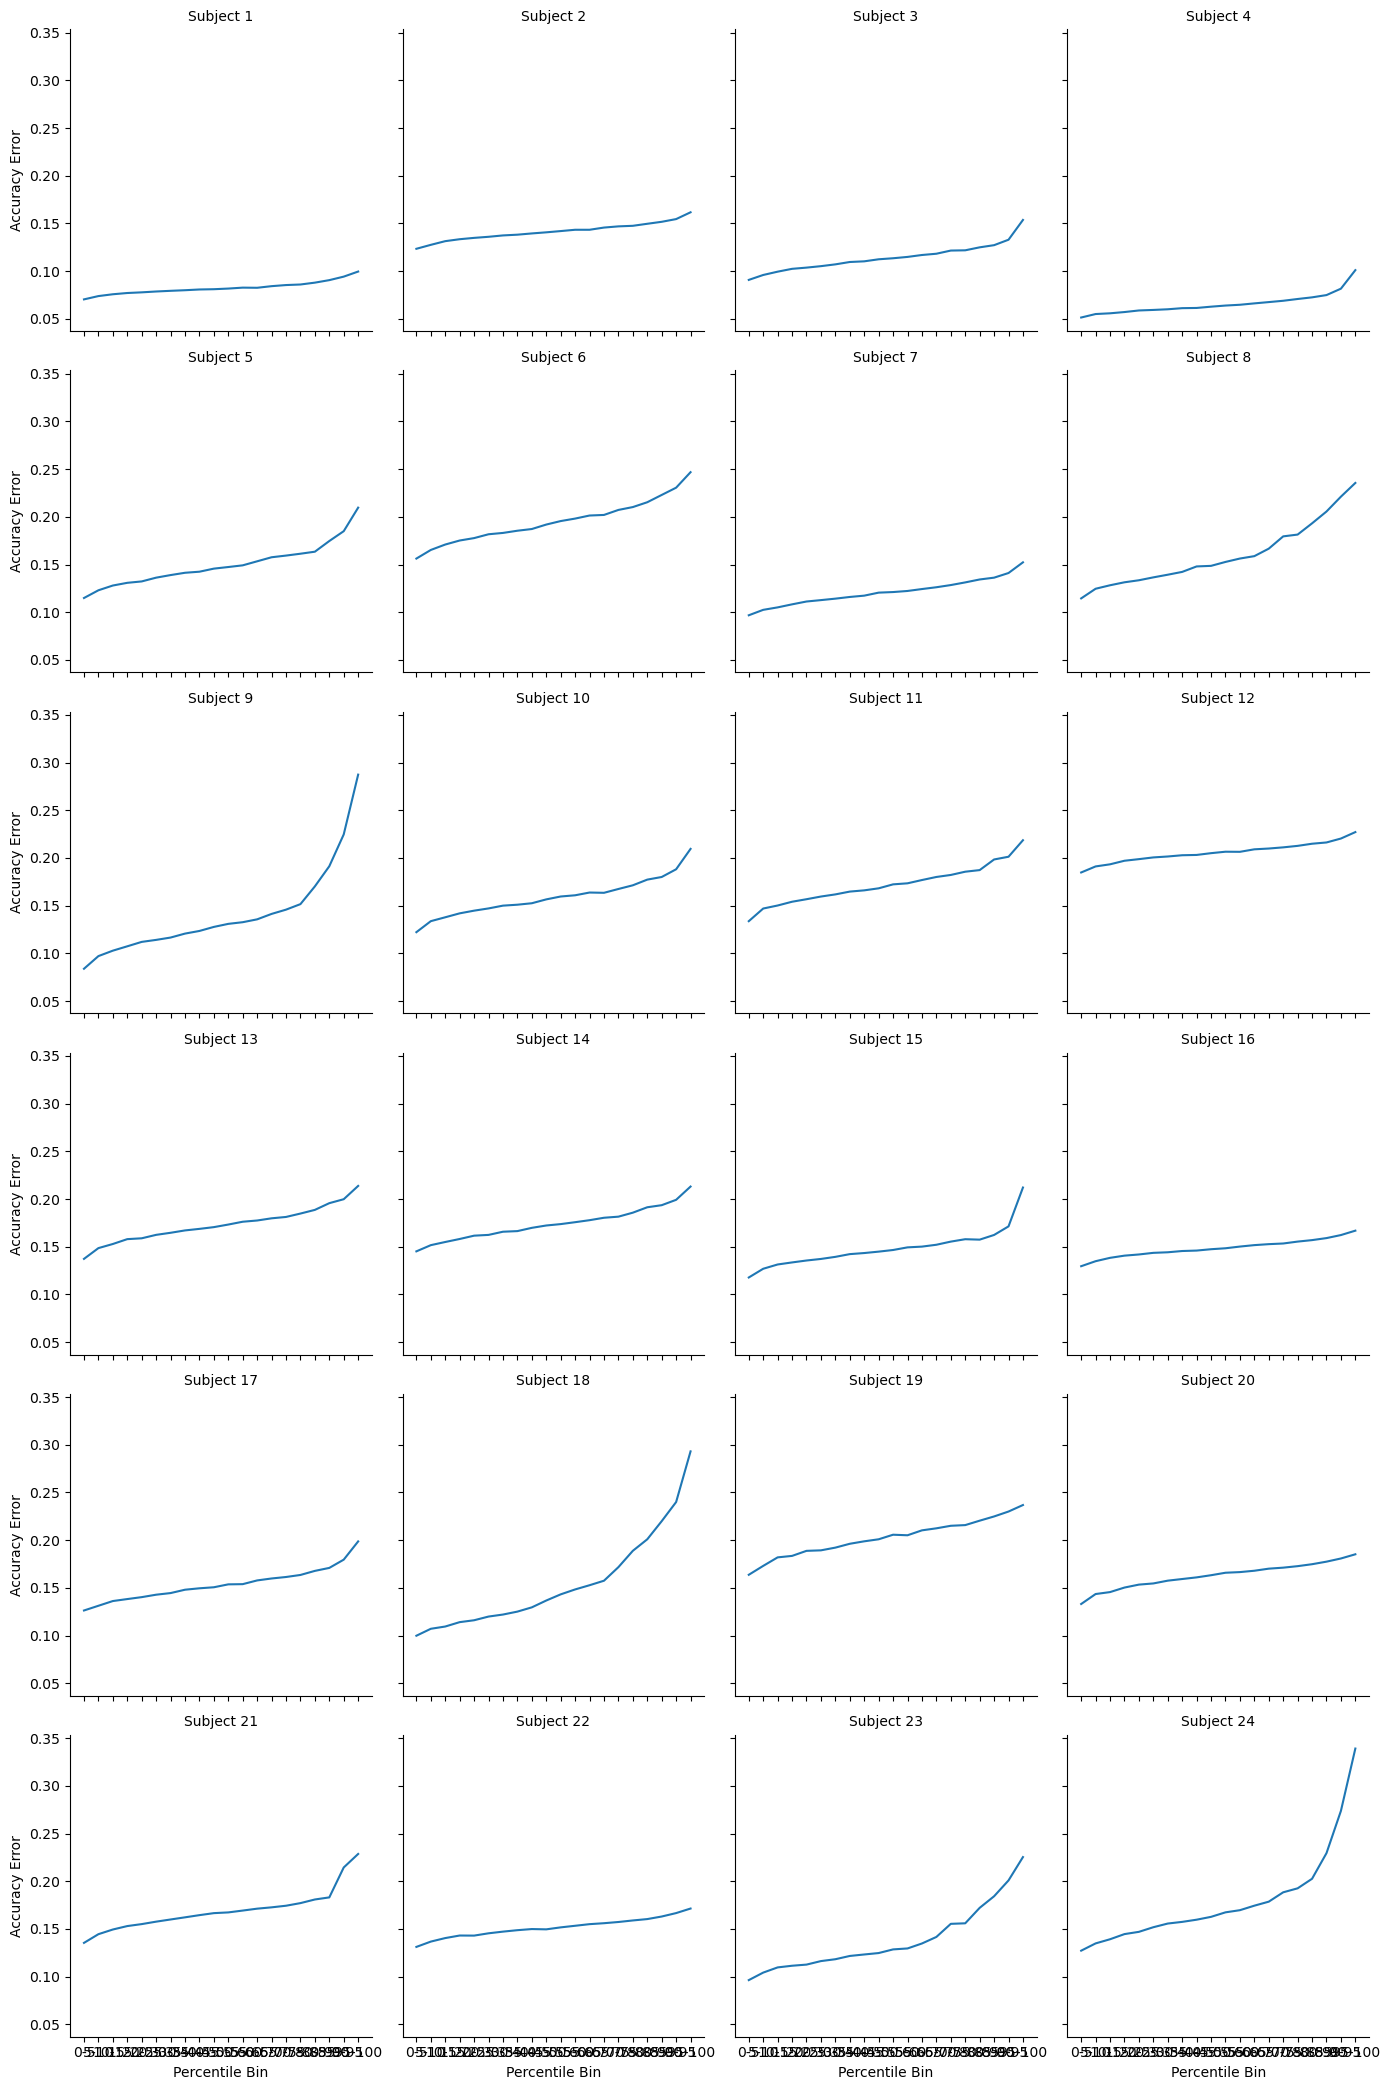

In [12]:
from matplotlib import pyplot as plt

# Accuracy error plot
g1 = sns.FacetGrid(df_eval_500, col='Subject', col_wrap=4, height=3.5)
g1.map_dataframe(sns.lineplot, x='Percentile_Bin', y='Accuracy_Error_Mean')
g1.set_axis_labels("Percentile Bin", "Accuracy Error")
g1.set_titles("Subject {col_name}")
# g1.suptitle("Accuracy Error vs. Top Trajectory Percentile", y=1.02)
plt.tight_layout()

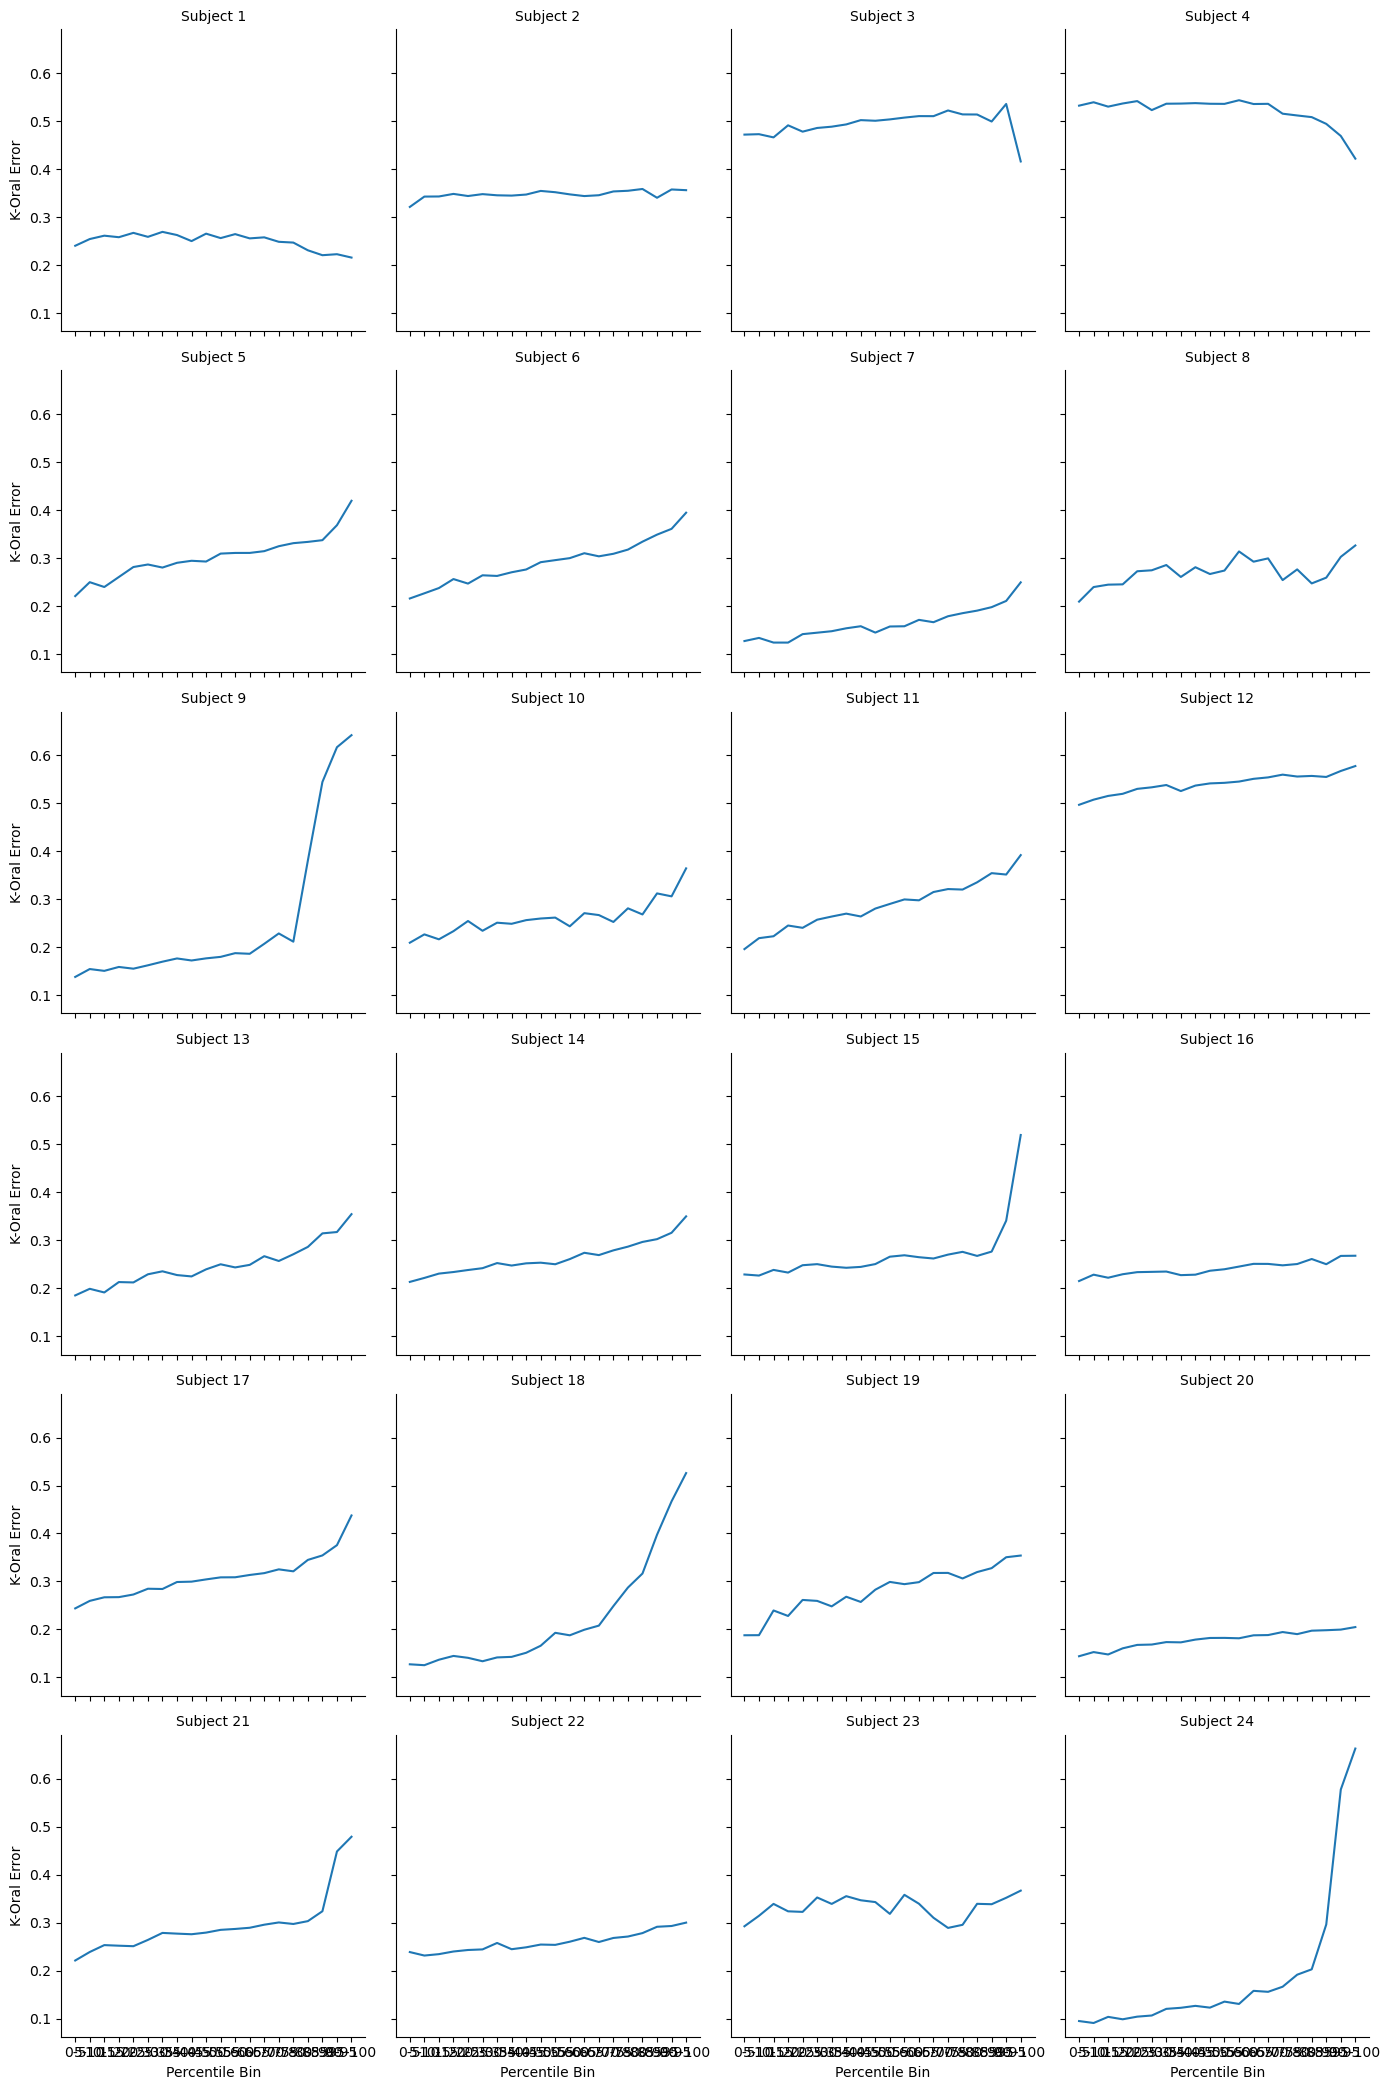

In [14]:
# K-Oral error plot
g2 = sns.FacetGrid(df_eval_500, col='Subject', col_wrap=4, height=3.5)
g2.map_dataframe(sns.lineplot, x='Percentile_Bin', y='KOral_Error_Mean')
g2.set_axis_labels("Percentile Bin", "K-Oral Error")
g2.set_titles("Subject {col_name}")
# g2.suptitle("K-Oral Error vs. Top Trajectory Percentile", y=1.02)
plt.tight_layout()

In [ ]:
df_eval_250 = compute_errors_fine_parallel_with_progress(results, oral_hypo_hits, 250, n_jobs=120)

In [19]:
joblib.dump(df_eval_250, result_path / f'{model_name}_sample_analysis_250.joblib')

['/home/yangjiong/CategoryLearning_gitcode/results/Model_results_new/M7_PMH_sample_analysis_250.joblib']

Computing errors:   0%|                               | 0/480 [2:55:46<?, ?it/s]


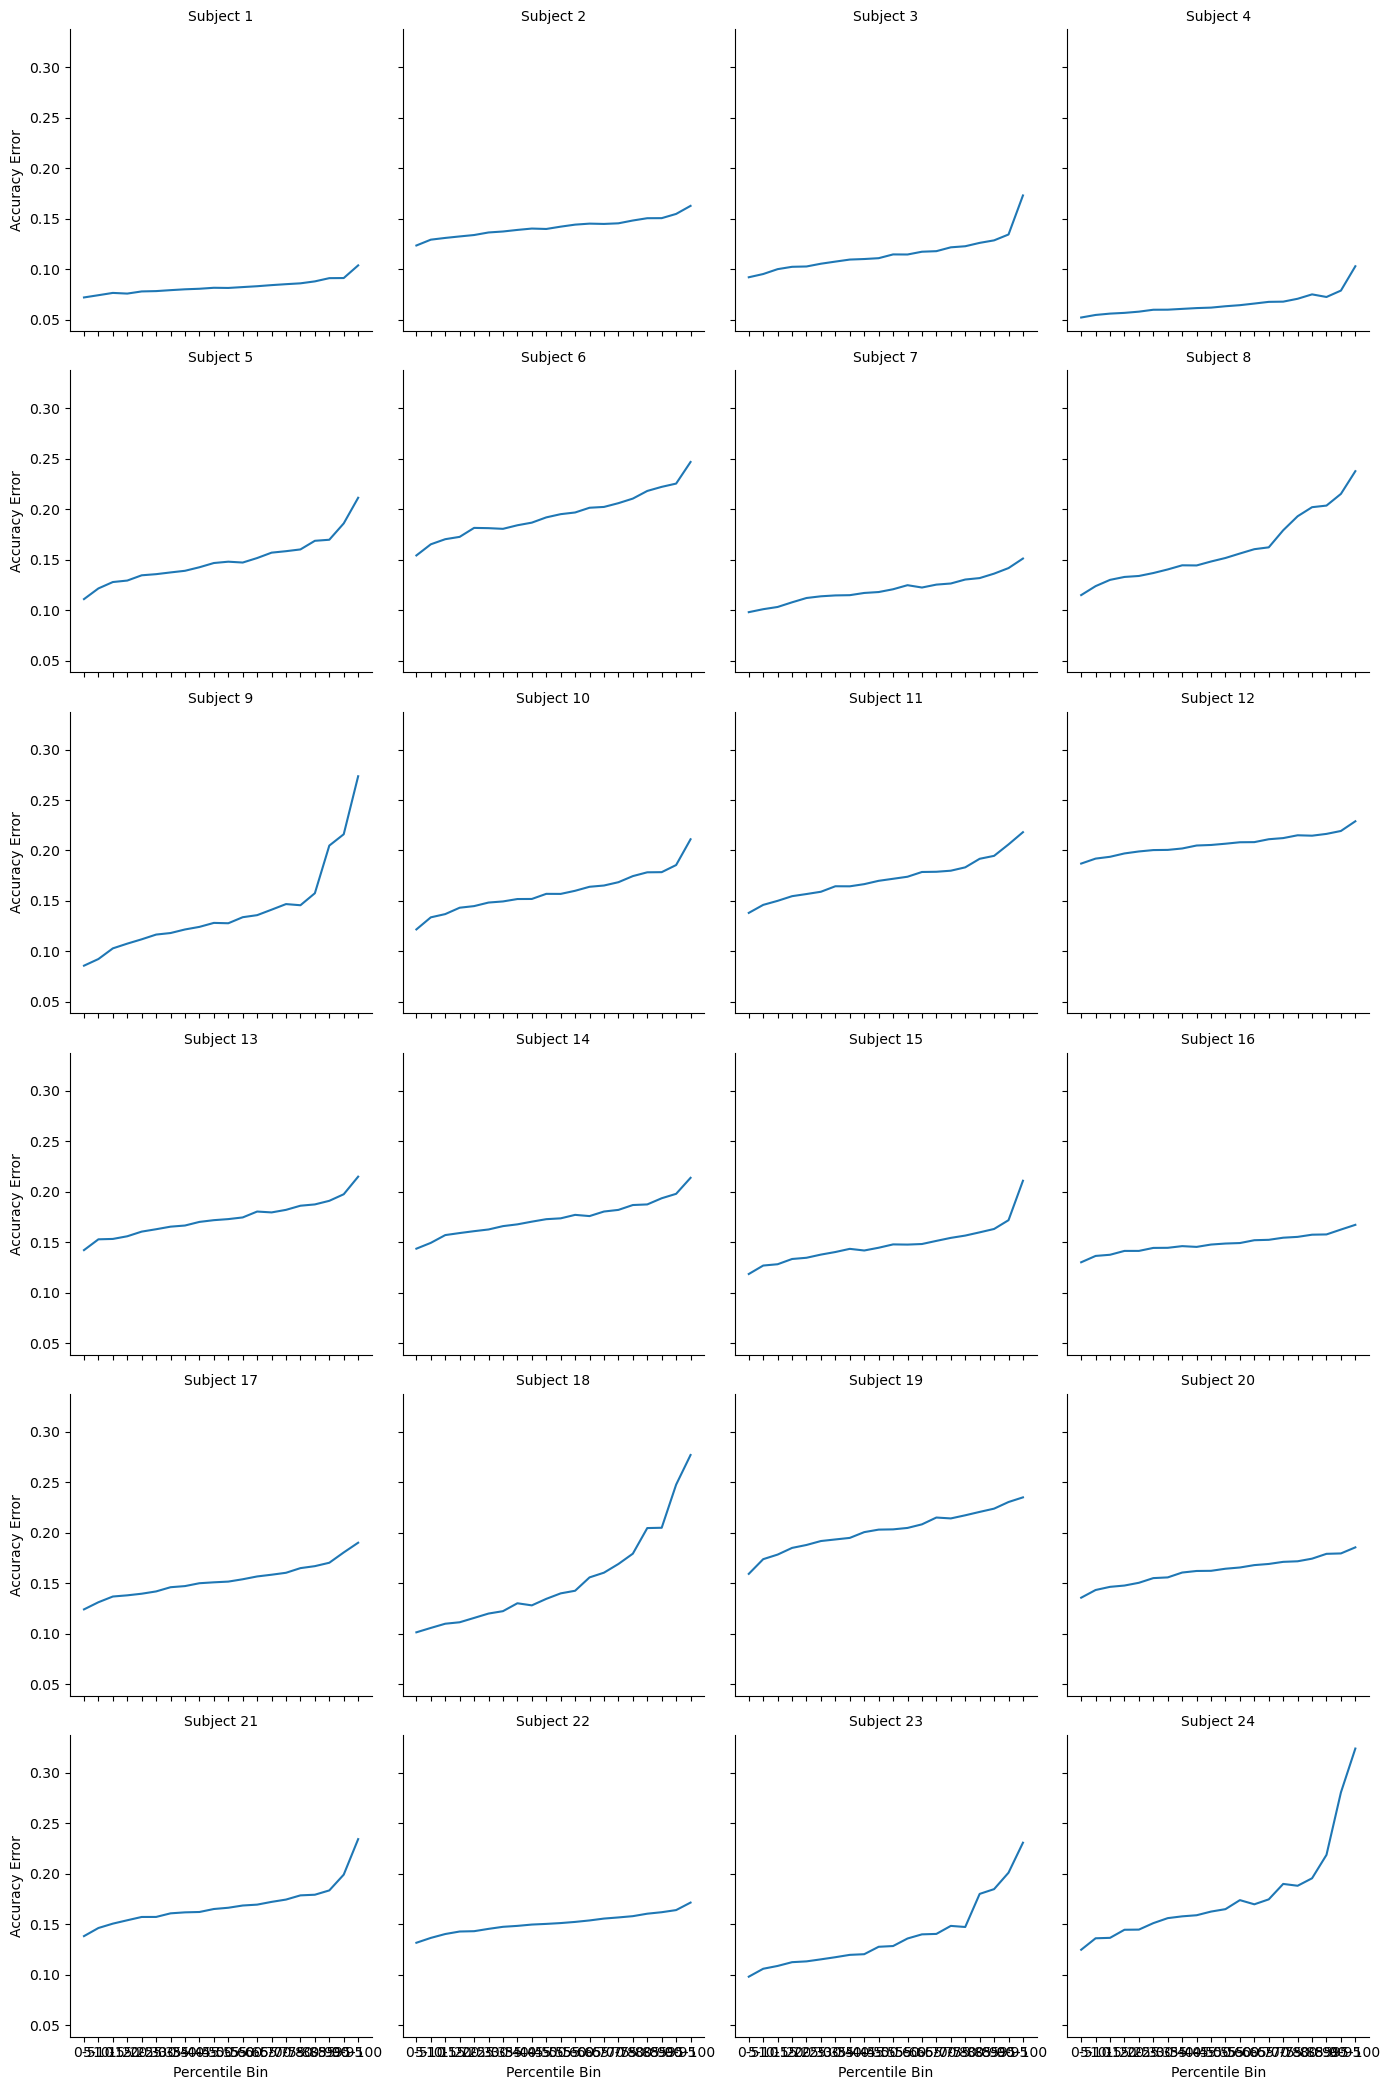

In [17]:
from matplotlib import pyplot as plt

# Accuracy error plot
g1 = sns.FacetGrid(df_eval_250, col='Subject', col_wrap=4, height=3.5)
g1.map_dataframe(sns.lineplot, x='Percentile_Bin', y='Accuracy_Error_Mean')
g1.set_axis_labels("Percentile Bin", "Accuracy Error")
g1.set_titles("Subject {col_name}")
# g1.suptitle("Accuracy Error vs. Top Trajectory Percentile", y=1.02)
plt.tight_layout()

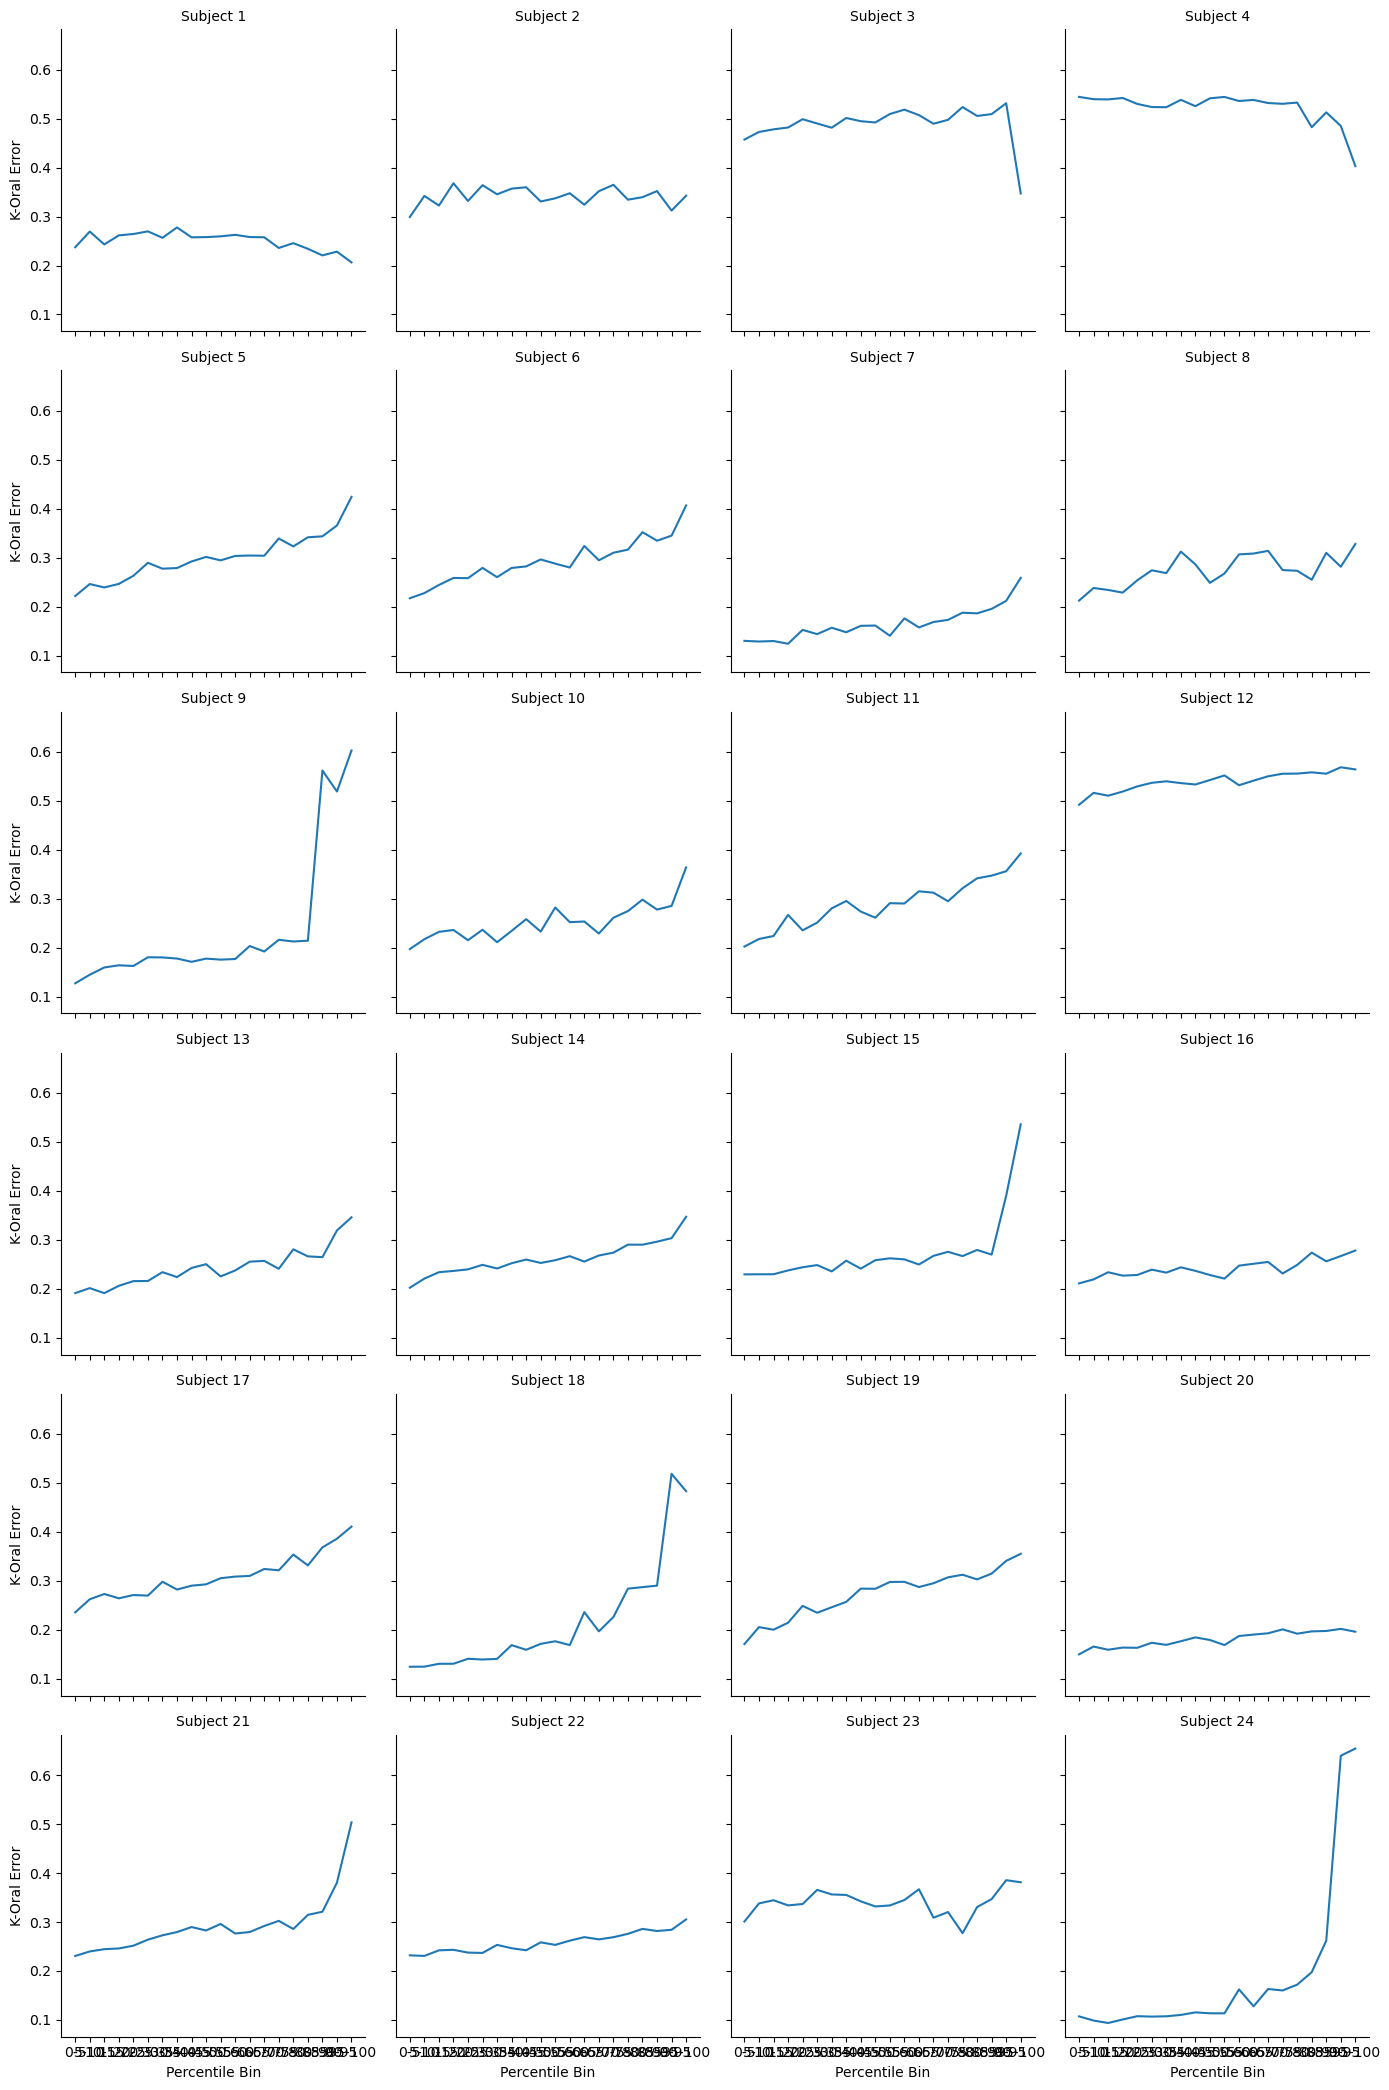

In [ ]:
# K-Oral error plot
g2 = sns.FacetGrid(df_eval_250, col='Subject', col_wrap=4, height=3.5)
g2.map_dataframe(sns.lineplot, x='Percentile_Bin', y='KOral_Error_Mean')
g2.set_axis_labels("Percentile Bin", "K-Oral Error")
g2.set_titles("Subject {col_name}")
# g2.suptitle("K-Oral Error vs. Top Trajectory Percentile", y=1.02)
plt.tight_layout()

In [20]:
df_eval_50 = compute_errors_fine_parallel_with_progress(results, oral_hypo_hits, 50, n_jobs=120)

Computing errors:   0%|                                 | 0/480 [00:00<?, ?it/s]

  0%|          | 0/480 [00:00<?, ?it/s]

In [21]:
joblib.dump(df_eval_50, result_path / f'{model_name}_sample_analysis_50.joblib')

['/home/yangjiong/CategoryLearning_gitcode/results/Model_results_new/M7_PMH_sample_analysis_50.joblib']

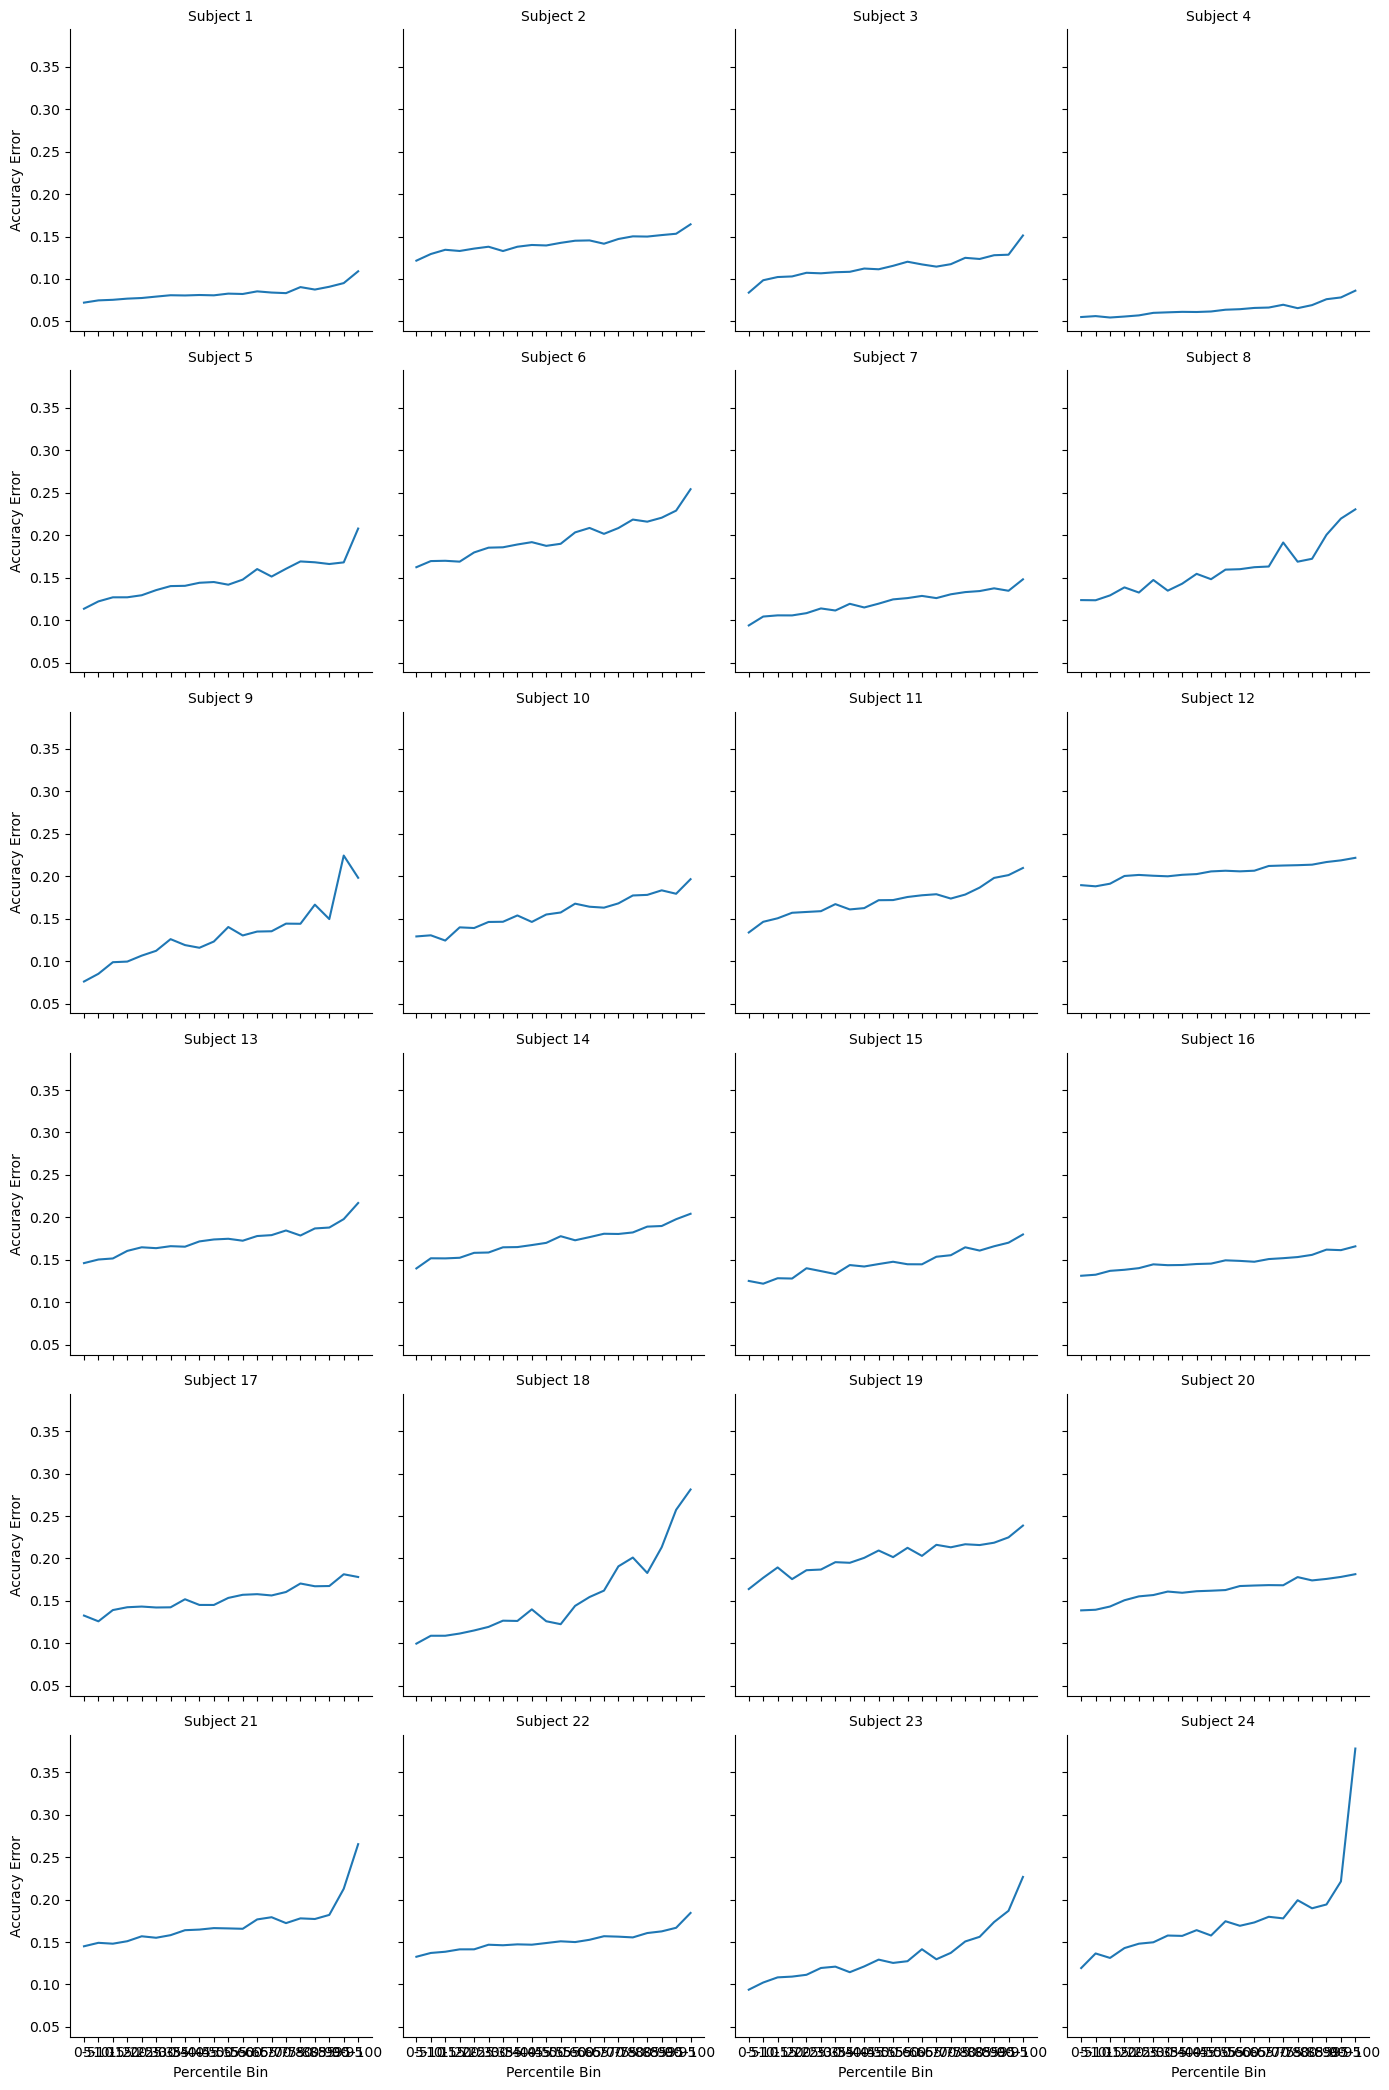

In [26]:
# K-Oral error plot
g2 = sns.FacetGrid(df_eval_50, col='Subject', col_wrap=4, height=3.5)
g2.map_dataframe(sns.lineplot, x='Percentile_Bin', y='Accuracy_Error_Mean')
g2.set_axis_labels("Percentile Bin", "Accuracy Error")
g2.set_titles("Subject {col_name}")
# g2.suptitle("K-Oral Error vs. Top Trajectory Percentile", y=1.02)
plt.tight_layout()

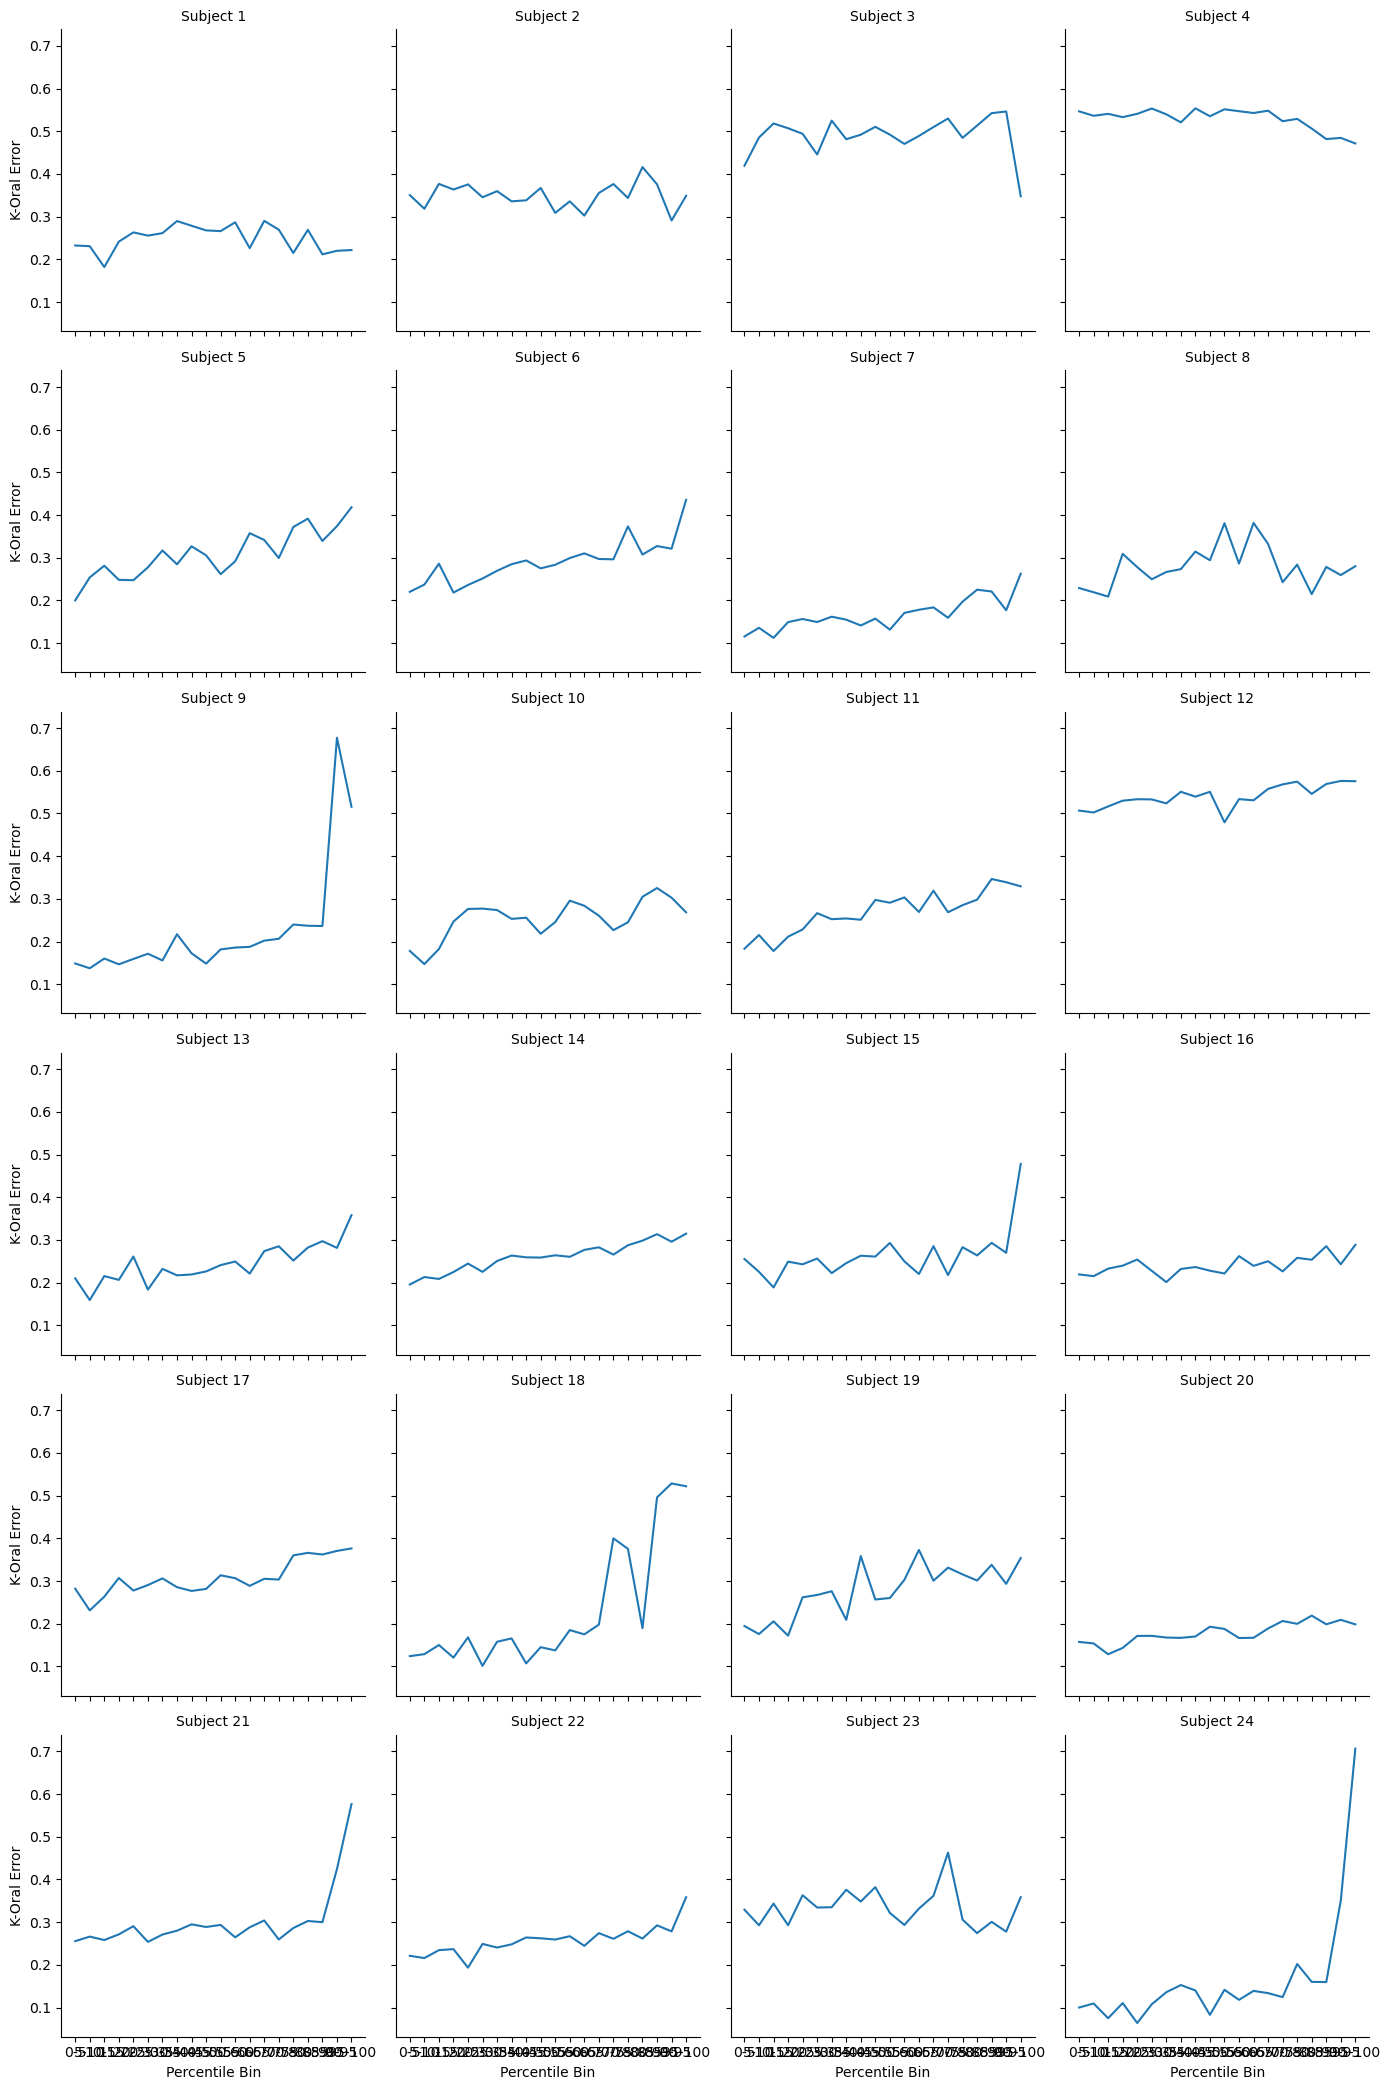

In [24]:
# K-Oral error plot
g2 = sns.FacetGrid(df_eval_50, col='Subject', col_wrap=4, height=3.5)
g2.map_dataframe(sns.lineplot, x='Percentile_Bin', y='KOral_Error_Mean')
g2.set_axis_labels("Percentile Bin", "K-Oral Error")
g2.set_titles("Subject {col_name}")
# g2.suptitle("K-Oral Error vs. Top Trajectory Percentile", y=1.02)
plt.tight_layout()